 <h1 style="text-align: center;">ESCUELA POLITÉCNICA NACIONAL</h1>
    <h2 style="text-align: center;">FACULTAD DE INGENIERÍA DE SISTEMAS</h2>
    <h3 style="text-align: center;">BUSINESS INTELLIGENCE</h3>
     <h3>INTEGRANTES GRUPO 8</h3>
    <h4>AUCAPIÑA GUANIN PAOLA MARIBEL</h4>
    <h4>IÑACASHA GORDILLO BYRON OSWALDO</h4>
    <h4>ZÚÑIGA NEGRETE VERÓNICA LUCÍA</h4>

# 10.7. Sequence-to-Sequence Learning for Machine Translation

In so-called sequence-to-sequence problems such as machine translation
(as discussed in  <span style="color:red;">Section 10.5</span>),
where inputs and outputs each consist 
of variable-length unaligned sequences,
we generally rely on encoder--decoder architectures
( <span style="color:red;">Section 10.6</span>).
In this section,
we will demonstrate the application 
of an encoder--decoder architecture,
where both the encoder and decoder 
are implemented as RNNs,
to the task of machine translation
( <span style="color:red;">Cho et al., 2014, Sutskever et al., 2014</span>)

Here, the encoder RNN will take a variable-length sequence as input 
and transform it into a fixed-shape hidden state.
Later, in <span style="color:red;">Section 11</span>,
we will introduce attention mechanisms, 
which allow us to access encoded inputs
without having to compress the entire input
into a single fixed-length representation.

Then to generate the output sequence, 
one token at a time,
the decoder model, 
consisting of a separate RNN,
will predict each successive target token
given both the input sequence
and the preceding tokens in the output.
During training, the decoder will typically
be conditioned upon the preceding tokens
in the official "ground truth" label. 
However, at test time, we will want to condition
each output of the decoder on the tokens already predicted. 
Note that if we ignore the encoder,
the decoder in a sequence-to-sequence architecture 
behaves just like a normal language model.
<span style="color:red;">Fig. 10.7.1</span> illustrates
how to use two RNNs
for sequence-to-sequence learning
in machine translation.

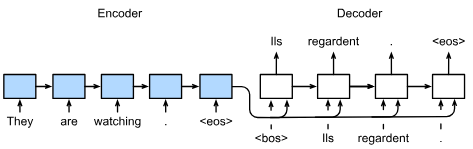
<center>Fig. 10.7.1 Sequence-to-sequence learning with an RNN encoder and an RNN decoder.</center>

In  <span style="color:red;">Fig 10.7.1</span>,
the special "&lt;eos&gt;" token
marks the end of the sequence.
Our model can stop making predictions
once this token is generated.
At the initial time step of the RNN decoder,
there are two special design decisions to be aware of:
First, we begin every input with a special 
beginning-of-sequence "&lt;bos&gt;" token.
Second, we may feed
the final hidden state of the encoder
into the decoder
at every single decoding time step ( <span style="color:red;"> Cho et al., 2014</span>).
In some other designs,
such as that of  Sutskever et al. ( <span style="color:red;">2014</span>),
the final hidden state of the RNN encoder
is used
to initiate the hidden state of the decoder
only at the first decoding step.

In [1]:
use strict;
use warnings;
use Data::Dump qw(dump);
use d2l;
IPerl->load_plugin('Chart::Plotly');
use jjap::numperl;# Importa el módulo jjap::numperl.
use AI::MXNet qw(mx); # Importa la clase mx del módulo AI::MXNet.
use List::Util qw(sum);# Importa la función sum del módulo
use constant np => 'numperl';# Define la constante np con el valor 

## 10.7.1. Teacher Forcing


While running the encoder on the input sequence
is relatively straightforward,
handling the input and output 
of the decoder requires more care. 
The most common approach is sometimes called *teacher forcing*.
Here, the original target sequence (token labels)
is fed into the decoder as input.
More concretely,
the special beginning-of-sequence token
and the original target sequence,
excluding the final token,
are concatenated as input to the decoder,
while the decoder output (labels for training) is
the original target sequence,
shifted by one token:
"&lt;bos&gt;", "Ils", "regardent", "." $\rightarrow$
"Ils", "regardent", ".", "&lt;eos&gt;" ( <span style="color:red;">Fig. 10.7.1</span>).

Our implementation in
 <span style="color:red;">Section 10.5.3</span>
prepared training data for teacher forcing,
where shifting tokens for self-supervised learning
is similar to the training of language models in
 <span style="color:red;">Section 9.3</span>.
An alternative approach is
to feed the *predicted* token
from the previous time step
as the current input to the decoder.


In the following, we explain the design 
depicted in  <span style="color:red;">Fig 10.7.1</span>
in greater detail.
We will train this model for machine translation
on the English--French dataset as introduced in
 <span style="color:red;">Section 10.5</span>.


## 10.7.2. Encoder

Recall that the encoder transforms an input sequence of variable length
into a fixed-shape *context variable* $\mathbf{c}$ (see <span style="color:red;"> Fig. 10.7.1.</span>).


Consider a single sequence example (batch size 1).
Suppose the input sequence is $x_1, \ldots, x_T$, 
such that $x_t$ is the $t^{\textrm{th}}$ token.
At time step $t$, the RNN transforms
the input feature vector $\mathbf{x}_t$ for $x_t$
and the hidden state $\mathbf{h} _{t-1}$ 
from the previous time step 
into the current hidden state $\mathbf{h}_t$.
We can use a function $f$ to express 
the transformation of the RNN's recurrent layer:

$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}). $$
(10.7.1)

In general, the encoder transforms 
the hidden states at all time steps
into a context variable through a customized function $q$:

$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T).$$
(10.7.2)

For example, in <span style="color:red;"> Fig. 10.7.1.</span>,
the context variable is just the hidden state $\mathbf{h}_T$
corresponding to the encoder RNN's representation
after processing the final token of the input sequence.

In this example, we have used a unidirectional RNN
to design the encoder,
where the hidden state only depends on the input subsequence 
at and before the time step of the hidden state.
We can also construct encoders using bidirectional RNNs.
In this case, a hidden state depends on the subsequence before and after the time step 
(including the input at the current time step), 
which encodes the information of the entire sequence.


Now let's implement the RNN encoder.
Note that we use an *embedding layer*
to obtain the feature vector for each token in the input sequence.
The weight of an embedding layer is a matrix,
where the number of rows corresponds to 
the size of the input vocabulary (`vocab_size`)
and number of columns corresponds to 
the feature vector's dimension (`embed_size`).
For any input token index $i$,
the embedding layer fetches the $i^{\textrm{th}}$ row 
(starting from 0) of the weight matrix
to return its feature vector.
Here we implement the encoder with a multilayer GRU.

In [2]:
package Seq2SeqEncoder {
    use base ("d2l::Encoder"); # Importa el módulo d2l::Module y lo establece como la clase base

    sub new { 
        (my $class, our %args) = (shift, d2l->get_arguments(vocab_size => undef, embed_size => undef, num_hiddens => undef, num_layers => undef, dropout => 0.0, \@_));
        my $self = $class->SUPER::new(); # Llama al constructor de la superclase para inicializar el objeto
            
        $self->{embedding} = mx->gluon->nn->Embedding($args{vocab_size}, $args{embed_size}); 
        $self->{rnn} = new d2l::GRU($args{num_hiddens}, $args{num_layers}, $args{dropout}); 
        map {$self->register_child($self->{$_})} ('embedding','rnn');
        $self->initialize(mx->init->Xavier());
        
        return bless($self, $class); # Asocia el objeto con la clase y lo devuelve
    }
    sub forward{
    
         my ($self, %args) = (shift, d2l->get_arguments(X => undef, \@_));
         my $embs = $self->{embedding}->forward(mx->nd->transpose($args{X}));
         my ($outputs, $state) = @{$self->{rnn}->forward($embs)};
    
         return [$outputs, $state];
    }
    
    1; 
}

1

Let's use a concrete example
to illustrate the above encoder implementation.
Below, we instantiate a two-layer GRU encoder
whose number of hidden units is 16.
Given a minibatch of sequence inputs `X`
(batch size $=4$; number of time steps $=9$),
the hidden states of the final layer
at all the time steps
(`enc_outputs` returned by the encoder's recurrent layers)
are a tensor of shape
(number of time steps, batch size, number of hidden units).


In [4]:
my ($vocab_size, $embed_size, $num_hiddens, $num_layers) = (10, 8, 16, 2);
my ($batch_size, $num_steps) = (4, 9);
my $encoder =   new Seq2SeqEncoder( $vocab_size, $embed_size, $num_hiddens, $num_layers);
print $encoder, "\n";
print $encoder->{embedding}, "\n";
print $encoder->{rnn}{rnn}, "\n";
my $X = mx->nd->zeros([$batch_size, $num_steps]);
my ($enc_outputs, $enc_state) = @{$encoder->forward($X)};
print $enc_outputs,"\n";
print $enc_state,"\n";
d2l->check_shape($enc_outputs, [$num_steps, $batch_size, $num_hiddens]);
d2l->list_params($encoder);

Seq2SeqEncoder(

)
Embedding(10 -> 8, float32)
GRU(16, TNC, num_layers=2)
<AI::MXNet::NDArray 9x4x16 @cpu(0)>
<AI::MXNet::NDArray 2x4x16 @cpu(0)>
embedding:
	0	embedding1_weight	<AI::MXNet::NDArray 10x8 @cpu(0)>
rnn:
	0	gru1_l0_i2h_weight	<AI::MXNet::NDArray 48x8 @cpu(0)>
	1	gru1_l0_h2h_weight	<AI::MXNet::NDArray 48x16 @cpu(0)>
	2	gru1_l0_i2h_bias	<AI::MXNet::NDArray 48 @cpu(0)>
	3	gru1_l0_h2h_bias	<AI::MXNet::NDArray 48 @cpu(0)>
	4	gru1_l1_i2h_weight	<AI::MXNet::NDArray 48x16 @cpu(0)>
	5	gru1_l1_h2h_weight	<AI::MXNet::NDArray 48x16 @cpu(0)>
	6	gru1_l1_i2h_bias	<AI::MXNet::NDArray 48 @cpu(0)>
	7	gru1_l1_h2h_bias	<AI::MXNet::NDArray 48 @cpu(0)>


Since we are using a GRU here,
the shape of the multilayer hidden states
at the final time step is
(number of hidden layers, batch size, number of hidden units).


In [5]:
# d2l.check_shape(enc_state, (num_layers, batch_size, num_hiddens))
d2l->check_shape($enc_state, [$num_layers, $batch_size, $num_hiddens]);

1

## 10.7.3. Decoder

Given a target output sequence $y_1, y_2, \ldots, y_{T'}$
for each time step $t'$
(we use $t^\prime$ to differentiate from the input sequence time steps),
the decoder assigns a predicted probability
to each possible token occurring at step $y_{t'+1}$
conditioned upon the previous tokens in the target
$y_1, \ldots, y_{t'}$ 
and the context variable 
$\mathbf{c}$, i.e., $P(y_{t'+1} \mid y_1, \ldots, y_{t'}, \mathbf{c})$.

To predict the subsequent token $t^\prime+1$ in the target sequence,
the RNN decoder takes the previous step's target token $y_{t^\prime}$,
the hidden RNN state from the previous time step $\mathbf{s}_{t^\prime-1}$,
and the context variable $\mathbf{c}$ as its input,
and transforms them into the hidden state 
$\mathbf{s}_{t^\prime}$ at the current time step.
We can use a function $g$ to express 
the transformation of the decoder's hidden layer:

$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}).$$
(10.7.3)

After obtaining the hidden state of the decoder,
we can use an output layer and the softmax operation 
to compute the predictive distribution
$p(y_{t^{\prime}+1} \mid y_1, \ldots, y_{t^\prime}, \mathbf{c})$ 
over the subsequent output token ${t^\prime+1}$.

Following <span style="color:red;"> Fig. 10.7.1.</span>,
when implementing the decoder as follows,
we directly use the hidden state at the final time step
of the encoder
to initialize the hidden state of the decoder.
This requires that the RNN encoder and the RNN decoder 
have the same number of layers and hidden units.
To further incorporate the encoded input sequence information,
the context variable is concatenated
with the decoder input at all the time steps.
To predict the probability distribution of the output token,
we use a fully connected layer
to transform the hidden state 
at the final layer of the RNN decoder.

In [6]:
package Seq2SeqDecoder {
    use base ("d2l::Decoder"); # Importa el módulo d2l::Module y lo establece como la clase base

    sub new { 
        (my $class, our %args) = (shift, d2l->get_arguments(vocab_size => undef, embed_size => undef, num_hiddens => undef, num_layers => undef, dropout => 0.0, \@_));
        my $self = $class->SUPER::new(); # Llama al constructor de la superclase para inicializar el objeto
            
        $self->{embedding} = mx->gluon->nn->Embedding($args{vocab_size}, $args{embed_size}); 
        $self->{rnn} = new d2l::GRU($args{num_hiddens}, $args{num_layers}, $args{dropout}); 
      #  map {$self->register_child($self->{$_})} ('embedding','rnn');
        $self->{dense}= mx->gluon->nn->Dense($args{vocab_size}, flatten=>0);
        $self->initialize(mx->init->Xavier());
        
        return bless($self, $class); # Asocia el objeto con la clase y lo devuelve
    }
    sub forward{
    
        my ($self, $X, $state) = (splice(@_, 0,2), d2l->get_arguments(\@_));
        my $embs = $self->embedding(mx->nd->transpose($X));
        my ($enc_output, $hidden_state) = $state;
        my $context = $enc_output->at(-1);
        $context = $context->expand_dims(0)->tile([$embs->shape->[0], 1, 1]);
        my $embs_and_context = mx->nd->concatenate([$embs, $context], -1);
        my ($outputs, $new_hidden_state) = $self->rnn($embs_and_context, $hidden_state);
        $outputs = $self->dense->($outputs)->swapaxes(0, 1);
        return $outputs, [$enc_output, $new_hidden_state];
    }
    
    1; 
}

1

In [8]:
package Seq2SeqDecoder{
  # The RNN decoder for sequence to sequence learning.
  use base ("d2l::Decoder");
sub new {
     my ( $class,  %args) = (shift, d2l->get_arguments(vocab_size=> undef,
                                                embed_size=> undef,
                                                num_hiddens=> undef,
                                                num_layers=> undef,
                                                dropout=> 0,  
                                                \@_));
    my  $self = $class->SUPER::new(); 
    $self->{embedding} = mx->gluon->nn->Embedding($args{vocab_size},$args{embed_size}); 
    $self->{rnn} = new d2l::GRU($args{num_hiddens}, $args{num_layers}, $args{dropout});
    $self->{dense}= mx->gluon->nn->Dense($args{vocab_size}, flatten=>0);
    map {$self->register_child($self->{$_})} ('embedding', 'rnn', 'dense');
    $self->initialize(mx->init->Xavier());
  return bless ($self, $class);  
}
sub init_state{
  my ($self, $enc_all_outputs, %args) = (splice(@_, 0, 2),d2l->get_arguments(\@_));                                     
  return $enc_all_outputs;
}
sub forward {
   my ($self, $X, $state) = (splice(@_, 0,2), d2l->get_arguments(\@_));
    my $embs = $self->{embedding}->forward(mx->nd->transpose($X)); 
    my ($enc_output, $hidden_state) = @{$state};
    my $context = $enc_output->slice([-1]);
     $context = mx->nd->tile($context, [$embs->shape->[0], 1, 1]);
    my $embs_and_context = mx->nd->concatenate([$embs, $context], axis => 2);
     ( my $outputs, $hidden_state) = @{$self->{rnn}->forward($embs_and_context, $hidden_state)};
    $outputs = $self->{dense}->forward($outputs)->swapaxes(0, 1);
    return ($outputs, [$enc_output, $hidden_state]);
}
1;
} 

1

Warning: Subroutine new redefined at reply input line 4.

Subroutine forward redefined at reply input line 23.


To illustrate the implemented decoder,
below we instantiate it with the same hyperparameters from the aforementioned encoder.
As we can see, the output shape of the decoder becomes (batch size, number of time steps, vocabulary size),
where the final dimension of the tensor stores the predicted token distribution.


In [9]:
my $decoder = new Seq2SeqDecoder($vocab_size, $embed_size, $num_hiddens, $num_layers);
print $decoder, "\n";
print $decoder->{embedding}, "\n";
print $decoder->{rnn}{rnn}, "\n";
print $decoder->{dense}, "\n";
my $state = $decoder->init_state($encoder->forward($X));
print $state, "\n";
print scalar @$state, "\n";
print "state->[0]: ", $state->[0], "\n";
print "state->[1]: ", $state->[1], "\n";
#(my $dec_outputs, $state) = @{$decoder->forward($X, $state)};
print "state->[1]: ", $state->[1], "\n";
#d2l->check_shape($dec_outputs, [$batch_size, $num_steps, $vocab_size]);
d2l->check_shape($state->[1], [$num_layers, $batch_size, $num_hiddens]);
#d2l->list_params($decoder);

Seq2SeqDecoder(

)
Embedding(10 -> 8, float32)
GRU(16, TNC, num_layers=2)
Dense(10 -> 0, linear)
ARRAY(0xc455600)
2
state->[0]: <AI::MXNet::NDArray 9x4x16 @cpu(0)>
state->[1]: <AI::MXNet::NDArray 2x4x16 @cpu(0)>
state->[1]: <AI::MXNet::NDArray 2x4x16 @cpu(0)>


1

The layers in the above RNN encoder--decoder model 
are summarized in <span style="color:red;"> Fig. 10.7.2.</span>

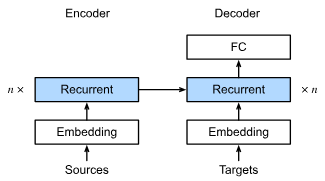
<center>Fig. 10.7.2 Layers in an RNN encoder–decoder model.</center>

## 10.7.4 Encoder–Decoder for Sequence-to-Sequence Learning

Putting it all together in code yields the following:

In [ ]:
class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [13]:
package Seq2Seq{
use base ("d2l::EncoderDecoder");

sub new {
    my ($class, %args) = (shift, d2l->get_arguments(encoder=>undef,
                                                decoder=>undef,
                                                tgt_pad=>undef,
                                                lr=>undef, 
                                                \@_));
    my  $self = $class->SUPER::new($args{encoder},$args{decoder}); 
    $self->save_hyperparameters(%args);
    return bless ($self, $class);
}

sub validation_step{
        my ($self, $batch) = @_; 
        my $Y_hat = $self->forward(@{$batch}[0 .. $#{$batch} - 1]);
        $self->plot('loss', $self->loss($Y_hat, $batch->[-1]), train => 0);
        $self->plot('loss', $self->loss($Y_hat, $batch->[3]), train => 0);

}
sub configure_optimizers{
      my $self = shift;
      return mx->gluon->Trainer( $self->parameters(), 
                                        optimizer => 'adam',
                                        optimizer_params => {learning_rate => $self->{lr}});  
}
  1;
}

1

Warning: Subroutine new redefined at reply input line 4.

Subroutine validation_step redefined at reply input line 15.

Subroutine configure_optimizers redefined at reply input line 22.


## 10.7.5. Loss Function with Masking

At each time step, the decoder predicts a probability distribution for the output tokens. As with language modeling, we can apply softmax to obtain the distribution and calculate the cross-entropy loss for optimization. Recall from <span style="color:red;"> Section 10.5</span> that the special padding tokens are appended to the end of sequences and so sequences of varying lengths can be efficiently loaded in minibatches of the same shape. However, prediction of padding tokens should be excluded from loss calculations. To this end, we can mask irrelevant entries with zero values so that multiplication of any irrelevant prediction with zero equates to zero.

In [14]:
my $loss = sub{
  my ($self, %args) = (shift, d2l->get_arguments(Y_hat=>undef, Y=>undef, \@_));
  my $l = $self->SUPER::loss($args{Y_hat}, $args{Y}, averaged=> 0);
  my $mask = ($args{Y}->reshape([-1])!= $self->{tgt_pad})->astype('float32'); 
  return mx->nd->sum($l * $mask) / mx->nd->sum($mask);
};

d2l->add_to_class('Seq2Seq', 'loss', $loss);

*Seq2Seq::loss

Warning: Subroutine Seq2Seq::loss redefined at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/d2l.pm line 4478.


## 10.7.6. Training

Now we can create and train an RNN encoder–decoder model for sequence-to-sequence learning on the machine translation dataset.

In [ ]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [15]:
my $data = new d2l::MTFraEng(batch_size=> 128);
($embed_size, $num_hiddens, $num_layers, my $dropout) = (256, 256, 2, 0.2);
$encoder = new Seq2SeqDecoder($data->{src_vocab}->len(), $embed_size,$num_hiddens,$num_layers,$dropout);
$decoder = new Seq2SeqDecoder($data->{tgt_vocab}->len(), $embed_size, $num_hiddens,$num_layers,$dropout);
my $model = new Seq2Seq($encoder,$decoder, tgt_pad=>$data->{tgt_vocab}->getitem('<pad>'), lr => 0.005);
my $trainer = new d2l::Trainer(max_epochs=>30, gradient_clip_val=>1, num_gpus=>1);
$trainer->fit($model, $data);

Error: Can't use an undefined value as an ARRAY reference at reply input line 26.
 at /usr/local/lib/perl5/site_perl/5.32.1/AI/MXNet/AutoGrad.pm line 408.
	AI::MXNet::AutoGrad::record("AI::MXNet::AutoGrad", CODE(0xd290988)) called at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/d2l.pm line 6733
	d2l::Trainer::fit_epoch(d2l::Trainer=HASH(0xc5ee030)) called at /usr/local/lib/perl5/site_perl/5.32.1/x86_64-linux/d2l.pm line 6659
	d2l::Trainer::fit(d2l::Trainer=HASH(0xc5ee030), Seq2Seq=HASH(0xc44e100), d2l::MTFraEng=HASH(0xc3bf760)) called at reply input line 7
	Eval::Closure::Sandbox_1599::__ANON__() called at /usr/local/lib/perl5/site_perl/5.32.1/Reply/Plugin/Defaults.pm line 71
	Reply::Plugin::Defaults::execute(Reply::Plugin::Defaults=HASH(0x4587f50), CODE(0x4c083b8), CODE(0xc450bb0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 217
	Reply::_wrapped_plugin(Reply=HASH(0x454fe38), ARRAY(0xc1c3f08), "execute", CODE(0xc450bb0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 215
	Reply::__ANON__(CODE(0xc450bb0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply/Plugin/IPerl.pm line 28
	Reply::Plugin::IPerl::__ANON__() called at /usr/local/lib/perl5/site_perl/5.32.1/Capture/Tiny.pm line 382
	eval {...} called at /usr/local/lib/perl5/site_perl/5.32.1/Capture/Tiny.pm line 382
	Capture::Tiny::_capture_tee(1, 1, 0, 0, CODE(0xc3cead8)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply/Plugin/IPerl.pm line 29
	Reply::Plugin::IPerl::execute(Reply::Plugin::IPerl=HASH(0x45a0918), CODE(0xc44c950), CODE(0xc450bb0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 217
	Reply::_wrapped_plugin(Reply=HASH(0x454fe38), "execute", CODE(0xc450bb0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 174
	Reply::_eval(Reply=HASH(0x454fe38), "\x{a}#line 1 \"reply input\"\x{a}my \$data = new d2l::MTFraEng(batch_siz"...) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 66
	Reply::try {...} () called at /usr/local/lib/perl5/site_perl/5.32.1/Try/Tiny.pm line 102
	eval {...} called at /usr/local/lib/perl5/site_perl/5.32.1/Try/Tiny.pm line 93
	Try::Tiny::try(CODE(0x4c082e0), Try::Tiny::Catch=REF(0xbece750)) called at /usr/local/lib/perl5/site_perl/5.32.1/Reply.pm line 71
	Reply::step(Reply=HASH(0x454fe38), "my \$data = new d2l::MTFraEng(batch_size=> 128);\x{a}(\$embed_size,"..., 0) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel/Backend/Reply.pm line 48
	Devel::IPerl::Kernel::Backend::Reply::__ANON__() called at /usr/local/lib/perl5/site_perl/5.32.1/Capture/Tiny.pm line 382
	eval {...} called at /usr/local/lib/perl5/site_perl/5.32.1/Capture/Tiny.pm line 382
	Capture::Tiny::_capture_tee(1, 1, 0, 0, CODE(0xdd4b310)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel/Backend/Reply.pm line 49
	Devel::IPerl::Kernel::Backend::Reply::run_line(Devel::IPerl::Kernel::Backend::Reply=HASH(0x1e1ca88), "my \$data = new d2l::MTFraEng(batch_size=> 128);\x{a}(\$embed_size,"...) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel/Callback/REPL.pm line 42
	Devel::IPerl::Kernel::Callback::REPL::execute(Devel::IPerl::Kernel::Callback::REPL=HASH(0x1f22408), Devel::IPerl::Kernel=HASH(0x20c1388), Devel::IPerl::Message::ZMQ=HASH(0xc44d418)) called at (eval 30) line 6
	Devel::IPerl::Kernel::Callback::REPL::execute(Devel::IPerl::Kernel::Callback::REPL=HASH(0x1f22408), Devel::IPerl::Kernel=HASH(0x20c1388), Devel::IPerl::Message::ZMQ=HASH(0xc44d418)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel/Callback/REPL.pm line 156
	Devel::IPerl::Kernel::Callback::REPL::msg_execute_request(Devel::IPerl::Kernel::Callback::REPL=HASH(0x1f22408), Devel::IPerl::Kernel=HASH(0x20c1388), Devel::IPerl::Message::ZMQ=HASH(0xc44d418), ZMQ::LibZMQ3::Socket=HASH(0x4bf4cb0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel.pm line 245
	Devel::IPerl::Kernel::route_message(Devel::IPerl::Kernel=HASH(0x20c1388), ARRAY(0x4bf4dd0), ZMQ::LibZMQ3::Socket=HASH(0x4bf4cb0)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel.pm line 215
	Devel::IPerl::Kernel::__ANON__(Net::Async::ZMQ::Socket=HASH(0x4bf4e60)) called at /usr/local/lib/perl5/site_perl/5.32.1/IO/Async/Loop/Poll.pm line 172
	IO::Async::Loop::Poll::post_poll(IO::Async::Loop::Poll=HASH(0x4af7478)) called at /usr/local/lib/perl5/site_perl/5.32.1/IO/Async/Loop/Poll.pm line 292
	IO::Async::Loop::Poll::loop_once(IO::Async::Loop::Poll=HASH(0x4af7478), undef) called at /usr/local/lib/perl5/site_perl/5.32.1/IO/Async/Loop.pm line 538
	IO::Async::Loop::run(IO::Async::Loop::Poll=HASH(0x4af7478)) called at /usr/local/lib/perl5/site_perl/5.32.1/IO/Async/Loop.pm line 575
	IO::Async::Loop::loop_forever(IO::Async::Loop::Poll=HASH(0x4af7478)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl/Kernel.pm line 225
	Devel::IPerl::Kernel::run(Devel::IPerl::Kernel=HASH(0x20c1388)) called at /usr/local/lib/perl5/site_perl/5.32.1/Devel/IPerl.pm line 14
	Devel::IPerl::main() called at -e line 1


## 10.7.7. Prediction

To predict the output sequence
at each step, 
the predicted token from the previous
time step is fed into the decoder as an input.
One simple strategy is to sample whichever token
that has been assigned by the decoder the highest probability
when predicting at each step.
As in training, at the initial time step
the beginning-of-sequence ("&lt;bos&gt;") token
is fed into the decoder.
This prediction process
is illustrated in <span style="color:red;"> Fig. 10.7.3.</span>.
When the end-of-sequence ("&lt;eos&gt;") token is predicted,
the prediction of the output sequence is complete.


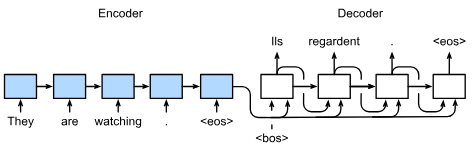
<center>Fig. 10.7.3 Predicting the output sequence token by token using an RNN encoder–decoder.</center>

In the next section, we will introduce 
more sophisticated strategies 
based on beam search <span style="color:red;">Section 10.8</span>.


## 10.7.8. Evaluation of Predicted Sequences

We can evaluate a predicted sequence
by comparing it with the
target sequence (the ground truth).
But what precisely is the appropriate measure 
for comparing similarity between two sequences?


Bilingual Evaluation Understudy (BLEU),
though originally proposed for evaluating
machine translation results (<span style="color:red;"> Papineni et al., 2002</span>),
has been extensively used in measuring
the quality of output sequences for different applications.
In principle, for any $n$-gram (<span style="color:red;">Section 9.3.1.1</span>) in the predicted sequence,
BLEU evaluates whether this $n$-gram appears
in the target sequence.

Denote by $p_n$ the precision of an $n$-gram,
defined as the ratio 
of the number of matched $n$-grams in
the predicted and target sequences
to the number of $n$-grams in the predicted sequence.
To explain, given a target sequence $A$, $B$, $C$, $D$, $E$, $F$,
and a predicted sequence $A$, $B$, $B$, $C$, $D$,
we have $p_1 = 4/5$,  $p_2 = 3/4$, $p_3 = 1/3$, and $p_4 = 0$.
Now let $\textrm{len}_{\textrm{label}}$ and $\textrm{len}_{\textrm{pred}}$
be the numbers of tokens in the target sequence 
and the predicted sequence, respectively.
Then, BLEU is defined as

$$ \exp\left(\min\left(0, 1 - \frac{\textrm{len}_{\textrm{label}}}{\textrm{len}_{\textrm{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$
(10.7.4)

where $k$ is the longest $n$-gram for matching.

Based on the definition of BLEU in <span style="color:red;">(10.7.4)</span>,
whenever the predicted sequence is the same as the target sequence, BLEU is 1.
Moreover,
since matching longer $n$-grams is more difficult,
BLEU assigns a greater weight
when a longer $n$-gram has high precision.
Specifically, when $p_n$ is fixed,
$p_n^{1/2^n}$ increases as $n$ grows (the original paper uses $p_n^{1/n}$).
Furthermore,
since
predicting shorter sequences
tends to yield a higher $p_n$ value,
the coefficient before the multiplication term in <span style="color:red;">(10.7.4)</span>
penalizes shorter predicted sequences.
For example, when $k=2$,
given the target sequence $A$, $B$, $C$, $D$, $E$, $F$ and the predicted sequence $A$, $B$,
although $p_1 = p_2 = 1$, the penalty factor $\exp(1-6/2) \approx 0.14$ lowers the BLEU.

We implement the BLEU measure as follows.


In the end, we use the trained RNN encoder–decoder to translate a few English sentences into French and compute the BLEU of the results.

## 10.7.9 Summary

Following the design of the encoder--decoder architecture, we can use two RNNs to design a model for sequence-to-sequence learning.
In encoder--decoder training, the teacher forcing approach feeds original output sequences (in contrast to predictions) into the decoder.
When implementing the encoder and the decoder, we can use multilayer RNNs.
We can use masks to filter out irrelevant computations, such as when calculating the loss.
For evaluating output sequences,
BLEU is a popular measure that matches $n$-grams between the predicted sequence and the target sequence.


## 10.7.10 Exercises

1. Can you adjust the hyperparameters to improve the translation results?
1. Rerun the experiment without using masks in the loss calculation. What results do you observe? Why?
1. If the encoder and the decoder differ in the number of layers or the number of hidden units, how can we initialize the hidden state of the decoder?
1. In training, replace teacher forcing with feeding the prediction at the previous time step into the decoder. How does this influence the performance?
1. Rerun the experiment by replacing GRU with LSTM.
1. Are there any other ways to design the output layer of the decoder?
